In [1]:
import axelrod as axl
import numpy as np
import matplotlib.pyplot as plt

class Agent():  # 当前行动 self.action;当前收益 self.reward;累积收益cul_reward;
    # 历史收益reward——history；历史行动 his_action
    # q表；历史q表q0_his;q1_his

    def __init__(self, learning_rate,i, **kwargs):
        self.learning_rate = learning_rate
        self.action_space = [0, 1]
        self.q = np.array([0.2, 0.2])
        self.idx=i
        self.action = np.random.randint(0,2)
        self.reward = 0
        self.cul_reward=0.01
       
        self.reward_history = []
        self.action_history = []

        self.policy = kwargs['policy']
        self.epsilon = kwargs['epsilon'] if self.policy == 'e_greedy' else 0
        self.q0_his = [0.2,]  # 初始值也可以设为0，但是设为0，可能曲线会上升的很慢，最初100论，合作比例不高
        self.q1_his = [0.2,]

    def choose_action(self):
        if self.policy == 'e_greedy':
            if np.random.rand() < self.epsilon or ((self.q == 0).any()):

                action = np.random.choice(self.action_space)
            else:
                if abs(self.q[0]-self.q[1])<1e-7:
                     action = np.random.choice(self.action_space)
                else:
                    action = np.argmax(self.q)

#         print(action)
        self.action = action
        
        return action

    def RL(self):
        self.action_history.append(self.action)
        self.reward_history.append(self.reward)
        self.cul_reward+=self.reward
        self.q[self.action] += self.learning_rate * (self.reward - self.q[self.action])
        self.q[self.action]=round(self.q[self.action],6)
        self.q0_his.append(self.q[0])
        self.q1_his.append(self.q[1])
        #self.round=0

    def reset(self):
        self.q = np.array([0.2, 0.2])
        self.action = np.random.randint(0,2)
        self.reward = 0
        self.cul_reward=0.01
        self.reward_history = []
        self.action_history = []

from axelrod.action import Action
from axelrod.player import Player

C = Action.C
D = Action.D



In [2]:
# 将经验决策方法改写成可以参加Axelrod锦标赛的策略
class long_EDM(Player):
    
    name = "long_EDM"
    
    classifier = {
        "memory_depth": 0,  # Memory-one Four-Vector = (p, p, p, p)
        "stochastic": True,
        "long_run_time": False,
        "inspects_source": False,
        "manipulates_source": False,
        "manipulates_state": False,
    }

    def __init__(self):
        super().__init__()
        self.agent = Agent(learning_rate=0.2, i=1, policy='e_greedy', epsilon=0.04)

    def strategy(self, opponent: Player):
        action = self.agent.choose_action()
        self.agent.RL()
        return C if action == 0 else D

In [3]:
# 将经验决策方法改写成可以参加Axelrod锦标赛的策略
class short_EDM(Player):
    
    name = "short_EDM"
    
    classifier = {
        "memory_depth": 0,  # Memory-one Four-Vector = (p, p, p, p)
        "stochastic": True,
        "long_run_time": False,
        "inspects_source": False,
        "manipulates_source": False,
        "manipulates_state": False,
    }

    def __init__(self):
        super().__init__()
        self.agent = Agent(learning_rate=0.8, i=1, policy='e_greedy', epsilon=0.04)

    def strategy(self, opponent: Player):
        action = self.agent.choose_action()
        self.agent.RL()
        return C if action == 0 else D

In [5]:
strategies = [
    axl.TitForTat(), 
    axl.Defector(), 
    axl.Bully(), 
    axl.WinStayLoseShift(), 
    axl.SuspiciousTitForTat(), 
    axl.Grumpy(), 
    axl.CyclerDC(), 
    axl.ZDExtortion(), 
    axl.Alternator(), 
    axl.WinShiftLoseStay(), 
    axl.Cooperator(), 
    axl.AntiTitForTat()
]
strategies.append(long_EDM())
strategies.append(short_EDM())

In [34]:
# 不同记忆长度EDM策略的收益能力对比


# 创建锦标赛
tournament = axl.Tournament(
    players=strategies,
    turns=200,
    repetitions=5
)

# 运行锦标赛
results = tournament.play()

results.ranked_names


Analysing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.78it/s]


['Defector',
 'Bully',
 'ZD-Extortion: 0.2, 0.1, 1',
 'Alternator',
 'Cycler DC',
 'Tit For Tat',
 'long_EDM',
 'short_EDM',
 'Win-Stay Lose-Shift',
 'Win-Shift Lose-Stay: D',
 'Suspicious Tit For Tat',
 'Grumpy: Nice, 10, -10',
 'Anti Tit For Tat',
 'Cooperator']

In [35]:
# 获取排名和得分情况
ranking = results.ranking
ranked_names = [strategies[i] for i in ranking]

# 输出排名和得分
print("排名和得分：")
for rank, strategy in enumerate(ranked_names, start=1):
    score = results.scores[ranking[rank-1]]
    print(f"{rank}. {strategy.name}: {score} 分")

# 输出标准化得分（每场比赛的平均得分）
print("\n标准化得分：")
for strategy, score in zip(strategies, results.normalised_scores):
    average_score = sum(score) / len(score)
    print(f"{strategy.name}: {average_score:.3f} 分")



排名和得分：
1. Defector: [7060, 6980, 6992, 7028, 7096] 分
2. Bully: [6270, 6262, 6276, 6230, 6129] 分
3. ZD-Extortion: [6099, 6166, 6692, 6194, 6507] 分
4. Alternator: [6076, 5995, 6050, 6030, 6104] 分
5. Cycler DC: [6077, 6034, 6065, 6019, 6044] 分
6. Tit For Tat: [6028, 6036, 6038, 6029, 6049] 分
7. long_EDM: [5951, 5977, 5909, 5938, 6066] 分
8. short_EDM: [5906, 5912, 5570, 6006, 5708] 分
9. Win-Stay Lose-Shift: [5899, 5902, 5905, 5853, 5871] 分
10. Win-Shift Lose-Stay: [5765, 5767, 5819, 5722, 5764] 分
11. Suspicious Tit For Tat: [5527, 5518, 5526, 5506, 5536] 分
12. Grumpy: [5303, 5265, 5459, 5306, 5458] 分
13. Anti Tit For Tat: [5229, 5316, 5211, 5212, 5135] 分
14. Cooperator: [4158, 4173, 4116, 4179, 4182] 分

标准化得分：
Tit For Tat: 2.322 分
Defector: 2.704 分
Bully: 2.397 分
Win-Stay Lose-Shift: 2.264 分
Suspicious Tit For Tat: 2.124 分
Grumpy: 2.061 分
Cycler DC: 2.326 分
ZD-Extortion: 2.435 分
Alternator: 2.327 分
Win-Shift Lose-Stay: 2.218 分
Cooperator: 1.601 分
Anti Tit For Tat: 2.008 分
long_EDM: 2.295 分

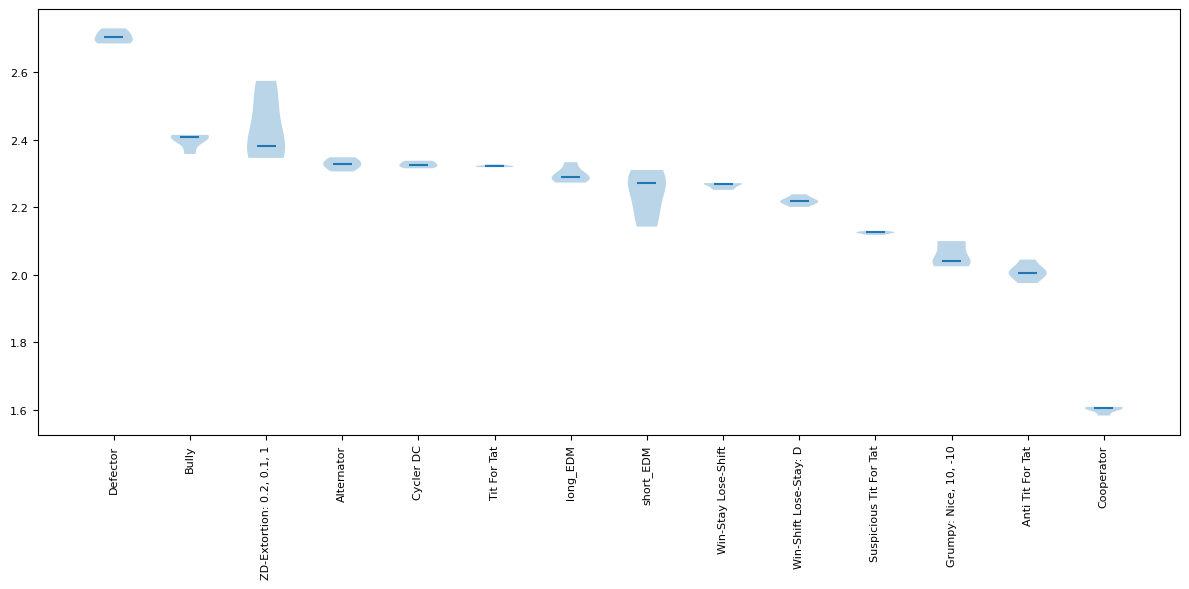

In [37]:
plot = axl.Plot(results)
plot.boxplot();

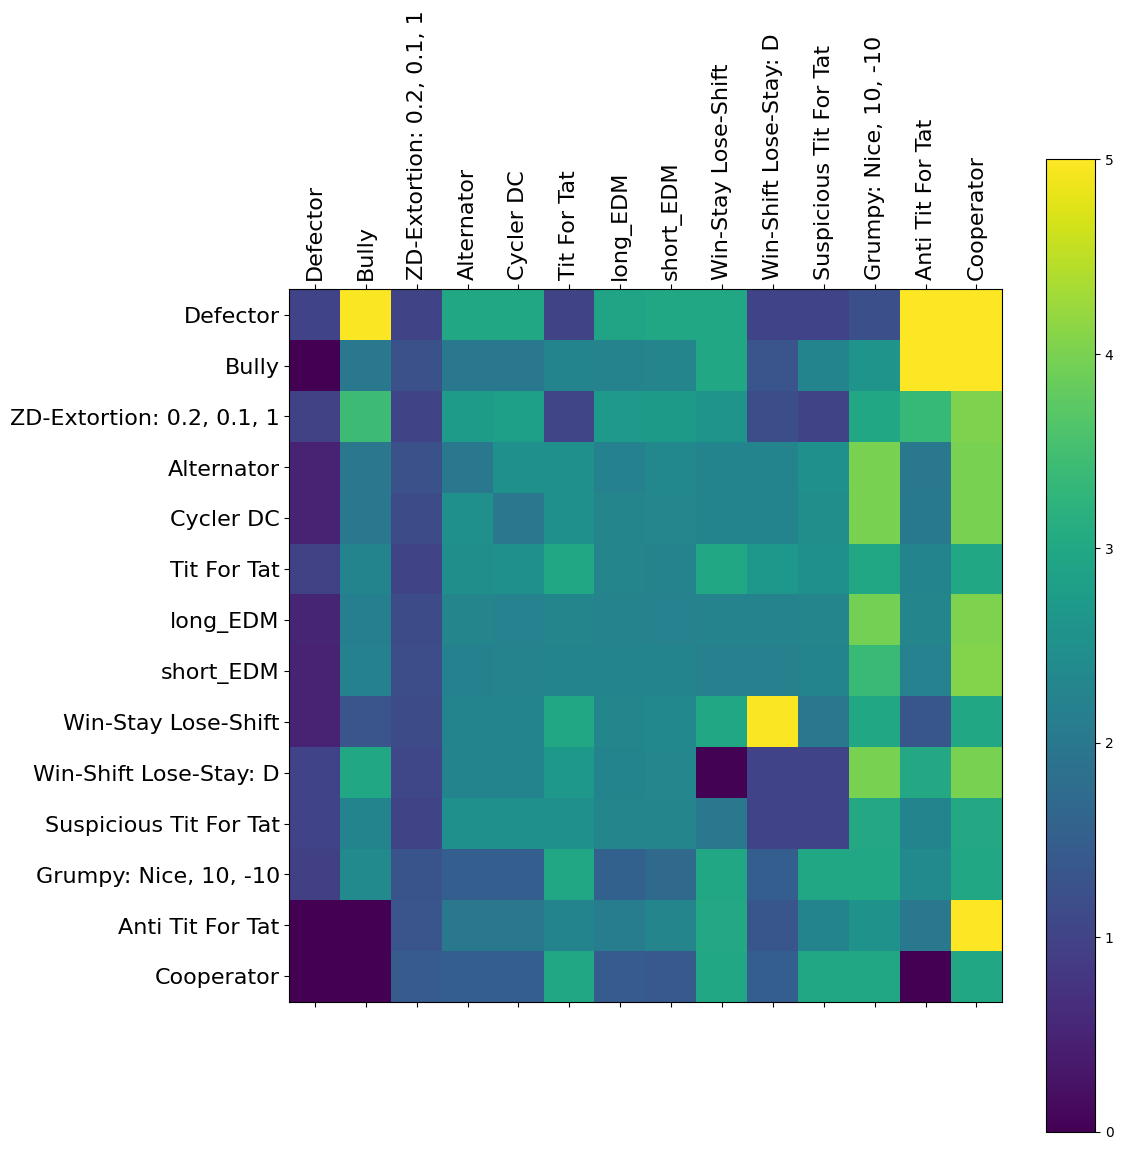

In [38]:
# 绘制支付矩阵
plot.payoff()
plt.show()

Playing matches:   5%|████▍                                                                                         | 5/105 [00:00<00:02, 40.79it/s]f:\mypython\mypy2\venv\lib\site-packages\axelrod\strategies\zero_determinant.py:93: RuntimeWarning: divide by zero encountered in long_scalars
  s_min = -min((T - l) / (l - S), (l - S) / (T - l))
Analysing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 90.32it/s]


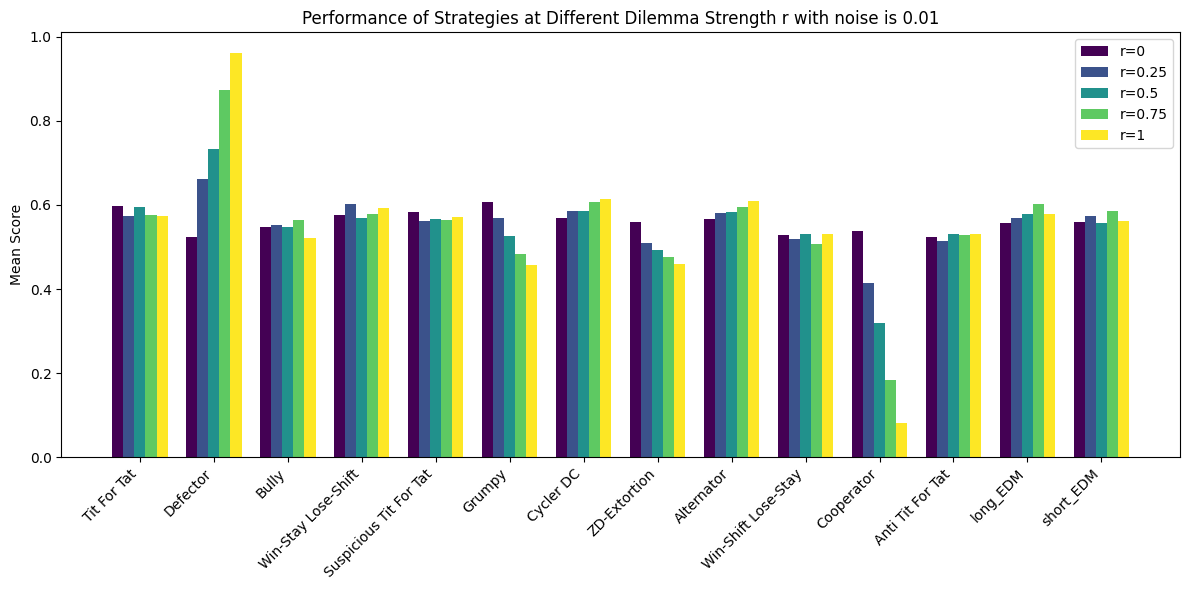

In [41]:
# 低噪声水平（%1）
# 困境强度 r 的值
r_values = [0, 0.25, 0.5, 0.75, 1]

# 存储每个策略在不同 r 值下的平均得分
strategy_scores = {strat.name: [] for strat in strategies}

# 对每个 r 值进行锦标赛
for r in r_values:
    # 定义收益矩阵
    R = 1
    S = -r
    T = 1 + r
    P = 0
    game = axl.Game(R, S, T, P)

    # 创建并运行锦标赛
    tournament = axl.Tournament(strategies, game=game, turns=200, repetitions=5, noise=0.01)
    results = tournament.play()

    # 获取并存储每个策略的平均得分
    scores = results.normalised_scores
    for strategy, score in zip(strategies, scores):
        strategy_scores[strategy.name].append(np.mean(score))

 # 绘制结果图表
fig, ax = plt.subplots(figsize=(12, 6))  # 调整图表大小
colors = plt.cm.viridis(np.linspace(0, 1, len(r_values)))  # 生成颜色数组
width = 0.15  # 条形的宽度

# 对每个策略绘制不同 r 值的得分
for i, r_val in enumerate(r_values):
    scores = [strategy_scores[strategy.name][i] for strategy in strategies]
    x = np.arange(len(scores))
    ax.bar(x + width*i, scores, width, label=f'r={r_val}', color=colors[i])

# 设置图表标题和标签
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Strategies at Different Dilemma Strength r with noise is 0.01')
ax.set_xticks(x + width * (len(r_values) - 1) / 2)
ax.set_xticklabels([strategy.name for strategy in strategies], rotation=45, ha="right")  # 旋转标签
ax.legend()

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()


Playing matches:   5%|████▍                                                                                         | 5/105 [00:00<00:02, 48.48it/s]f:\mypython\mypy2\venv\lib\site-packages\axelrod\strategies\zero_determinant.py:93: RuntimeWarning: divide by zero encountered in long_scalars
  s_min = -min((T - l) / (l - S), (l - S) / (T - l))
Analysing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 164.46it/s]


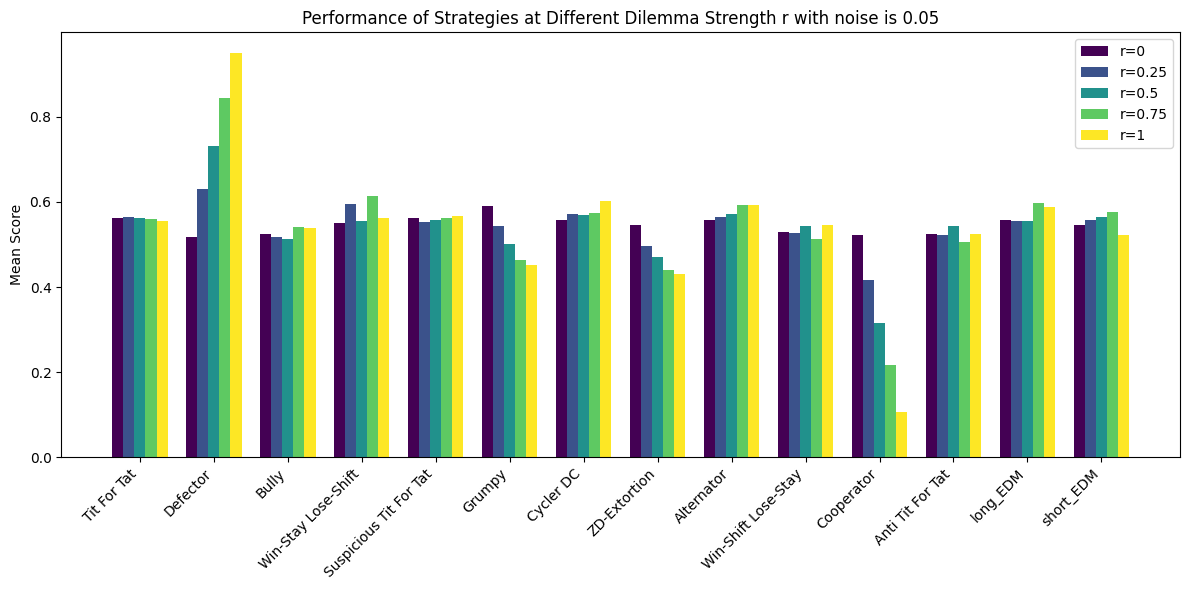

In [42]:
# 中噪声水平（%5）
# 困境强度 r 的值
r_values = [0, 0.25, 0.5, 0.75, 1]

# 存储每个策略在不同 r 值下的平均得分
strategy_scores = {strat.name: [] for strat in strategies}

# 对每个 r 值进行锦标赛
for r in r_values:
    # 定义收益矩阵
    R = 1
    S = -r
    T = 1 + r
    P = 0
    game = axl.Game(R, S, T, P)

    # 创建并运行锦标赛
    tournament = axl.Tournament(strategies, game=game, turns=200, repetitions=5, noise=0.05)
    results = tournament.play()

    # 获取并存储每个策略的平均得分
    scores = results.normalised_scores
    for strategy, score in zip(strategies, scores):
        strategy_scores[strategy.name].append(np.mean(score))

 # 绘制结果图表
fig, ax = plt.subplots(figsize=(12, 6))  # 调整图表大小
colors = plt.cm.viridis(np.linspace(0, 1, len(r_values)))  # 生成颜色数组
width = 0.15  # 条形的宽度

# 对每个策略绘制不同 r 值的得分
for i, r_val in enumerate(r_values):
    scores = [strategy_scores[strategy.name][i] for strategy in strategies]
    x = np.arange(len(scores))
    ax.bar(x + width*i, scores, width, label=f'r={r_val}', color=colors[i])

# 设置图表标题和标签
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Strategies at Different Dilemma Strength r with noise is 0.05')
ax.set_xticks(x + width * (len(r_values) - 1) / 2)
ax.set_xticklabels([strategy.name for strategy in strategies], rotation=45, ha="right")  # 旋转标签
ax.legend()

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()


Playing matches:   6%|█████▎                                                                                        | 6/105 [00:00<00:01, 52.32it/s]f:\mypython\mypy2\venv\lib\site-packages\axelrod\strategies\zero_determinant.py:93: RuntimeWarning: divide by zero encountered in long_scalars
  s_min = -min((T - l) / (l - S), (l - S) / (T - l))
Analysing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 109.46it/s]


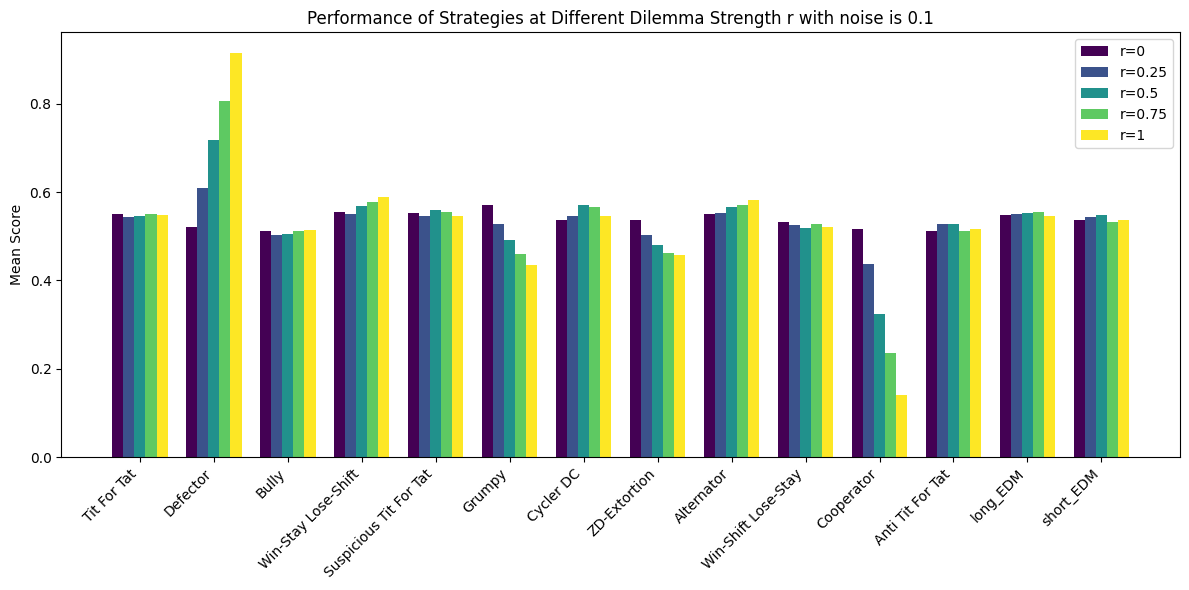

In [44]:
# 高噪声水平（%10）
# 困境强度 r 的值
r_values = [0, 0.25, 0.5, 0.75, 1]

# 存储每个策略在不同 r 值下的平均得分
strategy_scores = {strat.name: [] for strat in strategies}

# 对每个 r 值进行锦标赛
for r in r_values:
    # 定义收益矩阵
    R = 1
    S = -r
    T = 1 + r
    P = 0
    game = axl.Game(R, S, T, P)

    # 创建并运行锦标赛
    tournament = axl.Tournament(strategies, game=game, turns=200, repetitions=5, noise=0.1)
    results = tournament.play()

    # 获取并存储每个策略的平均得分
    scores = results.normalised_scores
    for strategy, score in zip(strategies, scores):
        strategy_scores[strategy.name].append(np.mean(score))

 # 绘制结果图表
fig, ax = plt.subplots(figsize=(12, 6))  # 调整图表大小
colors = plt.cm.viridis(np.linspace(0, 1, len(r_values)))  # 生成颜色数组
width = 0.15  # 条形的宽度

# 对每个策略绘制不同 r 值的得分
for i, r_val in enumerate(r_values):
    scores = [strategy_scores[strategy.name][i] for strategy in strategies]
    x = np.arange(len(scores))
    ax.bar(x + width*i, scores, width, label=f'r={r_val}', color=colors[i])

# 设置图表标题和标签
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Strategies at Different Dilemma Strength r with noise is 0.1')
ax.set_xticks(x + width * (len(r_values) - 1) / 2)
ax.set_xticklabels([strategy.name for strategy in strategies], rotation=45, ha="right")  # 旋转标签
ax.legend()

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()


In [13]:
# 延长比赛轮次对EDM策略的影响

M_values = [200, 1000, 5000]

# 存储每个策略在不同 r 值下的平均得分
strategy_scores = {strat.name: [] for strat in strategies}

# 对每个 r 值进行锦标赛
for M in M_values:
    # 创建并运行锦标赛
    tournament = axl.Tournament(strategies, turns=M, repetitions=5)
    results = tournament.play()
    # 获取排名和得分情况
    ranking = results.ranking
    ranked_names = [strategies[i] for i in ranking]
    
    # 输出排名和得分
    print("排名和得分：")
    for rank, strategy in enumerate(ranked_names, start=1):
        score = results.scores[ranking[rank-1]]
        print(f"{rank}. {strategy.name}: {score} 分")
        
    # 输出标准化得分（每场比赛的平均得分）
    print("\n标准化得分：")
    for strategy, score in zip(strategies, results.normalised_scores):
        average_score = sum(score) / len(score)
        print(f"{strategy.name}: {average_score:.3f} 分")
    
    # 获取并存储每个策略的平均得分
    scores = results.normalised_scores
    for strategy, score in zip(strategies, scores):
        strategy_scores[strategy.name].append(np.mean(score))


Analysing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 131.65it/s]


排名和得分：
1. Defector: [7036, 7020, 7072, 6996, 7072] 分
2. Bully: [6196, 6228, 6201, 6235, 6166] 分
3. ZD-Extortion: [6559, 6175, 6110, 6095, 6049] 分
4. Cycler DC: [6053, 5973, 6082, 6065, 6090] 分
5. Alternator: [6113, 6072, 5989, 6063, 6026] 分
6. Tit For Tat: [6057, 6021, 6050, 6049, 6016] 分
7. long_EDM: [6008, 5827, 5977, 5984, 6011] 分
8. short_EDM: [5770, 5891, 5958, 5746, 5974] 分
9. Win-Stay Lose-Shift: [5879, 5844, 5828, 5852, 5893] 分
10. Win-Shift Lose-Stay: [5718, 5769, 5748, 5732, 5727] 分
11. Suspicious Tit For Tat: [5501, 5512, 5540, 5526, 5524] 分
12. Grumpy: [5479, 5302, 5278, 5397, 5246] 分
13. Anti Tit For Tat: [5186, 5260, 5261, 5200, 5228] 分
14. Cooperator: [4095, 4158, 4230, 4149, 4185] 分

标准化得分：
Tit For Tat: 2.323 分
Defector: 2.707 分
Bully: 2.387 分
Win-Stay Lose-Shift: 2.254 分
Suspicious Tit For Tat: 2.123 分
Grumpy: 2.054 分
Cycler DC: 2.328 分
ZD-Extortion: 2.384 分
Alternator: 2.328 分
Win-Shift Lose-Stay: 2.207 分
Cooperator: 1.601 分
Anti Tit For Tat: 2.010 分
long_EDM: 2.293 分

Analysing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.75it/s]


排名和得分：
1. Defector: [34952, 35056, 35072, 35040, 35196] 分
2. Bully: [31200, 30891, 30928, 30899, 31124] 分
3. Alternator: [30080, 30072, 30255, 30175, 30261] 分
4. Cycler DC: [30401, 30138, 30146, 30157, 30089] 分
5. Tit For Tat: [30175, 30273, 30088, 30143, 30114] 分
6. ZD-Extortion: [29487, 29944, 30349, 29866, 29652] 分
7. short_EDM: [29773, 27199, 29587, 29307, 26695] 分
8. Win-Stay Lose-Shift: [29322, 29270, 29249, 29198, 29402] 分
9. Win-Shift Lose-Stay: [28743, 28699, 28651, 28522, 28557] 分
10. long_EDM: [27115, 27772, 29991, 28912, 27455] 分
11. Suspicious Tit For Tat: [27509, 27436, 27546, 27498, 27512] 分
12. Grumpy: [27509, 28779, 26738, 27315, 28929] 分
13. Anti Tit For Tat: [26134, 25838, 26215, 25993, 26076] 分
14. Cooperator: [20952, 20859, 20838, 20589, 20802] 分

标准化得分：
Tit For Tat: 2.320 分
Defector: 2.697 分
Bully: 2.385 分
Win-Stay Lose-Shift: 2.253 分
Suspicious Tit For Tat: 2.115 分
Grumpy: 2.143 分
Cycler DC: 2.322 分
ZD-Extortion: 2.297 分
Alternator: 2.321 分
Win-Shift Lose-Stay: 2

Analysing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 115.79it/s]

排名和得分：
1. Defector: [175248, 174936, 175024, 175292, 175072] 分
2. Bully: [155682, 155205, 155154, 155197, 155405] 分
3. Tit For Tat: [150753, 150866, 150919, 150801, 151047] 分
4. Alternator: [150478, 150814, 151151, 150958, 150636] 分
5. Cycler DC: [150697, 150796, 150794, 151018, 150981] 分
6. ZD-Extortion: [148047, 148122, 147964, 148830, 148333] 分
7. Win-Stay Lose-Shift: [146344, 146595, 146448, 146498, 146824] 分
8. long_EDM: [147997, 145068, 144665, 134814, 149239] 分
9. short_EDM: [132681, 143528, 146303, 140732, 148869] 分
10. Win-Shift Lose-Stay: [143686, 143374, 143078, 143258, 143565] 分
11. Suspicious Tit For Tat: [137460, 137524, 137588, 137427, 137459] 分
12. Grumpy: [140242, 137247, 136241, 142683, 132802] 分
13. Anti Tit For Tat: [130125, 130238, 130047, 130026, 130744] 分
14. Cooperator: [103983, 104220, 104511, 103992, 104010] 分

标准化得分：
Tit For Tat: 2.321 分
Defector: 2.694 分
Bully: 2.390 分
Win-Stay Lose-Shift: 2.254 分
Suspicious Tit For Tat: 2.115 分
Grumpy: 2.121 分
Cycler DC: 2.

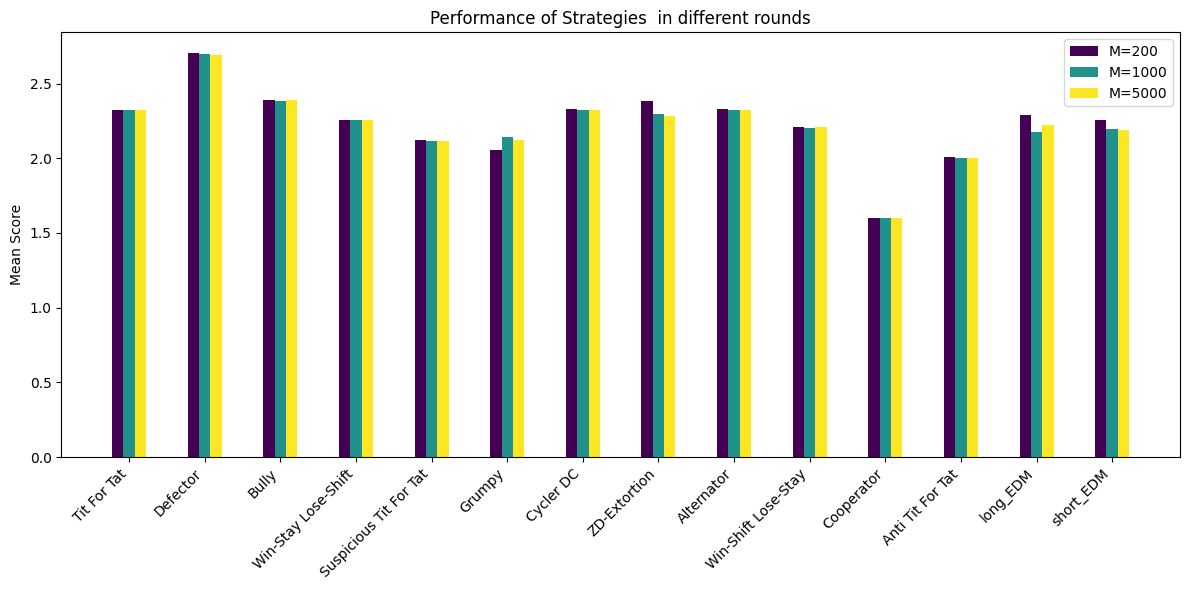

In [15]:
 # 绘制结果图表
fig, ax = plt.subplots(figsize=(12, 6))  # 调整图表大小
colors = plt.cm.viridis(np.linspace(0, 1, len(M_values)))  # 生成颜色数组
width = 0.15  # 条形的宽度

# 对每个策略绘制不同比赛轮次M的得分
for i, M_val in enumerate(M_values):
    scores = [strategy_scores[strategy.name][i] for strategy in strategies]
    x = np.arange(len(scores))
    ax.bar(x + width*i, scores, width, label=f'M={M_val}', color=colors[i])

# 设置图表标题和标签
ax.set_ylabel('Mean Score')
ax.set_title('Performance of Strategies  in different rounds')
ax.set_xticks(x + width * (len(M_values) - 1) / 2)
ax.set_xticklabels([strategy.name for strategy in strategies], rotation=45, ha="right")  # 旋转标签
ax.legend()

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()